# Exercise 1.2.1: Camera Calibration and Distortion Correction
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programee offered at Udacity.

## Objectives
* Understand camera calibration and radial distortions; 
* Write a function to perform camera calibration and distortion correction using [OpenCV]() functions;
* Test out your code on the set of object and image points ([`wide_dist_pickle.p`](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/files/Advanced_Lane_Finding_Images/correct_for_distortion/wide_dist_pickle.p)) and test image ([`test_image.png`](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/files/Advanced_Lane_Finding_Images/correct_for_distortion/test_image.png)) provided.

## 1. Introduction

In [1]:
### Setting environment variables

In [2]:
ENV_COLAB = False                # True if running in Google Colab instance

In [3]:
DIR_BASE = '' if not ENV_COLAB else '/content/'

In [4]:
### Importing required modules

In [5]:
from collections import defaultdict
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import os
import pandas as pd
import pickle
from typing import List

### 1.1. Camera Calibration

Our goal in this section is to establish a linear model such that the camera intrinsic parameters of matrix $\mathcal{K}$ can be estimated. 


#### Forewarning
This section is a rather deep dive into the algorithms behind the OpenCV [`calibrateCamera()`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d) and [`undistort()`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga69f2545a8b62a6b0fc2ee060dc30559d) methods. If linear algebra isn't your thing, jump to [Section 2](#2.-Programming-Task) for the code. 

#### Background

The basic notation used in this section is as follows:
* $p=\left[x, \ v\right]^{\top}$ denotes a 2D point in the image plane;
* $P = \left[X, \ Y, \ Z\right]^{\top}$ denotes a 3D point in the world coordinate frame;
* $\tilde{p}=\left[x, \ v, \ 1\right]^{\top}$ denotes an _augmented_ 2D point in the image plane;
* $\tilde{P} = \left[X, \ Y, \ Z, \ 1\right]^{\top}$ denotes an _augmented_ 3D point in the world coordinate frame.

##### Perspective projection model

The [perspective projection](https://en.wikipedia.org/wiki/3D_projection#Perspective_projection) is a linear projection where 3D objects are projected onto a 2D image plane. This projection introduces several parameters; _focal length_, _optical axis_, and _principal point_.

The distance $\mathcal{f}$ between the image plane and the centre of projection $O$ is known as the _focal length_. In digital cameras, this is the distance between the lens and camera image sensor. The _optical axis_, $O$, is a line through the 3D point $O$ (centre of projection) perpendicular to the image plane. The 
point of intersection of the _optical axis_ with the image plane is called the _principal point_, i.e., the image centre.

Mapping from 3D frame coordinates to 2D image coordinates requires the use of a [perspective transformation](https://en.wikipedia.org/wiki/3D_projection#Perspective_projection) from a 3D scene point $P$ onto the image plane at pixel $p$.

Using the pinhole camera model as a basis, we can form the relationship between a 3D point $\tilde{P}$ and its projection $\tilde{p}$ in the image plane:

$$
\begin{align}
    s \tilde{p} &= \mathcal{K}\left[R \ \ t\right]\tilde{P} \\
\end{align}
$$
as a mapping between the world coordinates in Euclidean 3-space, $\mathbb{R}^{3}$ to Euclidean 2-space, $\mathbb{R}^{2}$ with an arbitrary scale factor $s$ [1] (Zhang, 2000:3). Here $\mathcal{K}$ is the camera intrinsic matrix, $\left[R \ \ t\right]$ are the extrinsic parameters — the _rotation_ and _translation_, relating the world coordinate system to the camera coordinate system. 

![Fig. 1. The perspective projection.](figures/2022-08-10-Figure-1-Perspective-Projection.png)

$$
\begin{align}
\textrm{Fig. 1. The perspective projection model.}
\end{align}
$$

##### Intrinsic camera parameters

The intrinsic camera parameters characterise the optical, geometric, and digital characteristics of the camera, allowing us to map points in the world frame via perspective projection onto the image plane. These include:
* The perspective projection (focal length $\mathcal{f}$);
* The transformation between image plane and pixel coordinates;
* The geometric distortion coefficients introduced by optics.

The camera calibration matrix $\mathcal{K}$ can be defined as an upper triangular $3x3$ matrix with 11 degrees of freedom,

$$
\begin{align} 
    \mathcal{K} &\stackrel{\text{def}}{=}
        \begin{pmatrix}
            \alpha_{x} & s      & x_0 \\
            0      & \alpha_{y} & y_0 \\
            0      & 0          & 1
        \end{pmatrix}.\\             
    \end{align}
$$

The terms $\alpha_{x}$ and $\alpha_{y}$ are known as the _scale_ factors in the $x$- and $y$-direction in the image plane. The _principal point_ $\left(x_0, y_0\right)^{\top}$ has a _skewness_ parameter $s$ describing the offset of the two image axes (non-zero when the principal point is not exactly centre with the image plane). The _aspect ratio_ is given as $\alpha = \alpha_{y}\ / \ \alpha_{x}$.

The camera intrinsic matrix may also include parameters to handle geometric distortion, namely the radial distortion coefficients $k_1, k_2, k_3$, which we will see in the later section.

##### Extrinsic camera parameters

The _extrinsic_ parameters allow us to go from image coordinates in pixels to 3D point reconstructions in the world coordinate frame. These include:
* Rotation;
* Translation.

The intrinsic parameters and extrinsic camera parameters describe the camera and image coordinate frames as well as the position and orientation of the camera in the world frame. In this exercise we will discover a common linear model to extract these parameters and obtain both the camera _calibration_ and _projection_ matrices. With these two matrices, we can effectively handle and correct for radial distortion. 

Scale plays a challenging role in understanding monocular image information, once points are projected from 3D onto 2D image plane -- all scale information is then lost. Points in 3D space along the ray from camera centre all project to same position on image plane. Because of this, it is not possible to directly associate depth to a point given only image information 

#### Camera calibration algorithm

The camera calibration algorithm relies on several assumptions of the world and camera coordinate systems. Once the camera coordinate frame is defined, the intrinsic parameters can be derived. The computed 3D points and their 2D point correspondences in an image can be associated manually or automatically using a _calibration target_. With the camera intrinsic matrix and point correspondences known, we can solve the calibration problem using a similar approach to the [direct linear transformation](https://en.wikipedia.org/wiki/Direct_linear_transformation) (DLT). A least-squares solution to the linear system of equations exists and is computed with [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) in order to solve for the parameters of the camera matrix (the rotation and translation). 

In summary:
1. Define the world and camera coordinate frames;
2. Model the 3D world-to-camera coordinate transformations;
3. Apply a perspective projection to obtain 3D camera to 2D image coordinates;
4. Solve the linear system of equations to obtain the camera projection matrix.

##### Note on calibration targets

A calibration target is a scene object with known geometry, i.e., scale and size. This object of known geometry — often a flat, two-dimensional $m\times n$ chessboard pattern, provides us with a map of fixed-point locations to observe in an uncalibrated image.

A core assumption we will make when using the chessboard calibration pattern is the elimination of the $z$-coordinate axis on the basis of a flat surface assumption, i.e., all chessboard corners lie on the 2D $x$-$y$ plane. We will see later on that this assumption allows us to simplify the projection matrix from a $3\times4$ to a $3\times3$ matrix.

##### Homography between model plane and its image

We assume that the model plane has $Z$-coordinate axis values equal to zero, i.e., $Z = 0$, such that the homogenous coordinate mapping from camera coordinate frame to pixel image coordinates,
$$
\begin{align}
    \begin{bmatrix}
        x \\ y \\ 1
        \end{bmatrix}
    \rightarrow
    \begin{bmatrix}
        X \\ Y \\ 1
        \end{bmatrix} 
    \end{align}
$$

becomes the following:

$$
\begin{align}
    x &= K\begin{bmatrix}r_1, \ r_2, \ t \end{bmatrix} X.
    \end{align}
$$

This relation between the camera coordinate frame and the _world_ coordinate frame is such that the last column $r_3$ of the rotation matrix $\mathcal{R}$ has been eliminated for our model plane assumption $Z = 0$. This simplifies our estimate of the projection matrix $P$ to a $3\times3$ homography instead of the standard $3\times4$ projection matrix.

With the size and structure of the chessboard known, we can obtain the corner coordinates relative to the 2D surface of the calibration target. The 3D location of these chessboard corners, however, remain unknown in the world coordinate frame.

For each point observed $i$ on the chessboard, we have
$$
\begin{equation*}
\begin{aligned}[p]
    \begin{bmatrix}
      x_{i} \\ y_{i} \\ 1
     \end{bmatrix} 
     &=
      \underbrace{
       \begin{bmatrix}
         \alpha_{x} & s & x_{0} \\
         0 & \alpha_{y} & y_{0} \\
         0 & 0 & 1
        \end{bmatrix}}_{\mathcal{K}}
         \underbrace{
          \begin{bmatrix}
            r_{1,1} & r_{1,2} & t_{1} \\
            r_{2,1} & r_{2,2} & t_{2} \\
            r_{3,1} & r_{3,2} & t_{3}
           \end{bmatrix}}_{\left[r_1, \ r_2, \ t\right]}
            \begin{bmatrix}
              X_{i} \\ Y_{i} \\ 1
              \end{bmatrix}
\end{aligned}
\qquad
\begin{aligned}[p]
    i &= 1,...,N \\
\end{aligned}
\end{equation*}
$$

which results in a system of known and unknown equations for $N$ object points. 

Vectorising the matrix $h = \left( h_{k} \right) = \mathrm{vec}\left( H^{\top} \right)$ and forming the relation
$$
\begin{align}
\alpha_{y_{i}}^{\top}h &= 0, \\
\alpha_{x_{i}}^{\top}h &= 0
\end{align}
$$

results in a DLT-like estimation with 9 DoF (5 intrinsics, 4 extrinsics up to a scale factor; normalising by $H_{3,3}$ results in 8 DoF).

##### Note on minimum observations

Minimum number of calibration target images needed for $K$ images, each with $M$ corners:
* No. parameters: $4 + 6K$,
* No. constraints: $2K*M$,
* Assertion: $2K*M \geq 4+ 6K \Rightarrow M > 3$ and $K \geq 2/(M-3)$

Therefore, we need a minimum of $K=3$ images, each with $M=4$ corner points.

##### The closed-form solution (Zhang, 2000)

###### Setting up the linear system

Since we have have a $3\times3$ matrix $H$ and not a $3\times4$ matrix $P$ by the elimination of the third column of $\mathcal{R}$, we _cannot_ apply QR decomposition to extract our intrinsic matrix $\mathcal{K}$. 

Instead, we will use SVD and form a relation between matrix $H$ and the upper triangular matrix $K$ with unknown $R = \left[r_1, \ r_2, \ t\right]$. Note here that this $R$ is not the standard _rotation_ matrix which we could apply QR decomposition to, but rather the decomposition of the intrinsic calibration matrix $\mathcal{K}$. 

Thus we have the relation:
$$
\begin{align}
    H &= \left[h_1 \ h_2 \ h_3 \right] = K\left[ r_1 \ r_2 \ t \right] \\
    \end{align}
$$
where $K$ is assumed to be the invertible, upper triangular camera intrinsic matrix $\mathcal{K}$,
$$
\begin{align}
    \left[ r_1 \ r_2 \ t \right] &= K^{-1}\left[h_1 \ h_2 \ h_3 \right].
    \end{align}
$$

We start constructing the homogenous linear system by defining a matrix $B = K^{-1}K^{-\top}$ and placing additional constraints on the column vectors $r_1, r_2$,
$$
\begin{align}
    r_1 &= K^{-1}h_1, \\
    r_2 &= K^{-1}h_2. \\
    \end{align}
$$

By property of the rotation matrix $\mathcal{R}$, we know that the column vectors $r_1, \ r_2$ form an orthonormal basis, i.e.,
$$
\begin{align}
    r_1^{\top}r_2 &= 0, \\
    \Vert r_1 \Vert &=  \Vert r_2 \Vert = 1. \\
    \end{align}
$$

Exploiting this fact we can relate $\mathcal{K}$ and $h$ by substituting these constraints into our system of equations to obtain
$$
\begin{align}
    h_1^{\top}K^{-\top}K^{-1}h_2 &= 0. \\
    \end{align}
$$

Knowing from the second constraint that $r_1, r_2$ are unit vectors of length 1, we can rearrange the above to obtain:
$$
\begin{align}
    h_1^{\top}K^{-\top}K^{-1}h_1 - h_2^{\top}K^{-\top}K^{-1}h_2 &= 0. \\
    \end{align}
$$

We now have two equations that relate the unkown and known elements of which will be used to form our homogenous linear system.

###### Solving with Cholesky decomposition and least squares
Letting matrix $B$ be a $3\times3$ symmetric and positive matrix such that $B = K^{-\top}K^{-1}$, we can make a substitution above and compute the standard matrix decomposition of $B$ using a [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) method,
$$
\begin{align}
    \textrm{chol}(B) &= AA^{\top} \quad \textrm{such that} \quad A = K^{-\top}. \\
    \end{align}
$$ 

With the Cholesky decomposition we can directly compute the camera calibration matrix $\mathcal{K}$ from the product of $B$. In order to solve for $B$, we will consider two equations that relate $B$ (unknown) and $h$ (known). Defining the linear system of equations and exploiting the previous constraints we have
$$
\begin{equation*}
 \begin{aligned}
    v_{1,2}^{\top}b &= 0, \\
  \end{aligned}
\qquad
 \begin{aligned}
    v_{1,1}^{\top}b - v_{2,2}^{\top}b &= 0.
  \end{aligned}
\end{equation*}
$$

In order to solve this sytem using a direct linear transformation (DLT), we will stack the coefficients of $b$ into a $6\times1$ column vector. For each image, we have $Vb = 0$ with matrix $V_{[2\times6]}$ such that
$$
\begin{equation*}
 \begin{aligned}
    V &= \begin{pmatrix}
        v_{1,2}^{\top} \\
        v_{1,1}^{\top} - v_{2,2}^{\top}
    \end{pmatrix}, \\
  \end{aligned}
\quad \textrm{with} \quad
 \begin{aligned}
    v_{i,j} &= \begin{bmatrix}
        h_{1,i}h_{1,j} \\
        h_{1,i}h_{2,j} + h_{2,i}h_{1,j} \\
        h_{3,i}h_{1,j} + h_{1,i}h_{3,j} \\
        h_{2,i}h_{2,j} \\
        h_{3,i}h_{2,j} + h_{2,i}h_{3,j} \\
        h_{3,i}h_{3,j}
    \end{bmatrix}.
  \end{aligned}
\end{equation*}
$$

For multiple images, we stack the matrices to form a $2n\times6$ matrix to then solve the linear system $Vb = $ to obtain $b$ and therefore $K$.

Using least squares and SVD we can find the solution that minimises the error
$$
\begin{align}
    b^{*} &= \arg\!\min_{b} \Vert Vb \Vert, \\
    \end{align}
$$
which can be solved using the DLT approach.

### 1.2. Geometric Distortion Correction

#### Background

Geometric distortions are a type of third-order _primary aberration_ which alter the apparent geometry of an image. These distortions appear as deformations to or unatural curving of lines in an image and often disrupt the image quality. The severity of geometric distortion is determined by the optical design and geometric properties of the camera lens and its individual elements used to capture the image. In this exercise, we will be covering a subset of geometric distortions known as _radial distortions_.

Radial distortions occur as a result of small differences in focal length between the individual lens elements of a camera lens. Distortions of this type present themselves in images in two common forms: _barrel_ and _pincushion_.

![Fig. 2. Common types of Radial Distortion — Barrel and Pincushion.](figures/2022-08-10-Figure-2-Radial-Distortions.png)

$$
\begin{align}
    \textrm{Fig. 2. Common types of radial distortion — barrel and pincushion.} \\
    \end{align}
$$

Barrel distortions _negatively_ alter the image field of view (FOV) while pincushion distortions _positively_ alter the FOV. With barrel distortions, points along the scene periphery (outer-most corners) are squeezed inward towards the centre where the magnification increases. With pincushion distortions, points along the periphery are stretched outward as the magnification decreases in the centre. 

#### Correcting for distortion

Correcting projection distortions such as radial distortion can be done with several techniques. The first  involves _re-mapping_ image points based on optical design data provided by camera lens manufacturers. This is known as a physical-model based mapping approach [3]. A second, more common technique is to use a testing target with known geometry, e.g., chessboard, to _calibrate_ out the estimated percentage of distortion in an image. Not only is this global distortion-mapping approach a more practical approach, this calibration method can also be more computationally efficient than the former when correcting for radial distortion.

Since our distortion type is known a priori, matching a single optical distortion model is our best bet. We will start by using the object and image points provided to us with [chessboard detection](https://en.wikipedia.org/wiki/Chessboard_detection). These correspond to the 3D and 2D point coordinates of the chessboard. The 3D `object` points are the locations of the corners of each square on the chessboard, whereas `image` points are the 2D pixel coordinates in the image. These are projections of the object points that contain radial distortion.

##### Modelling radial distortion

The displacement due to radial distortion can be modelled by the following set of even-order polynomial equations [1] (Zhang, 2000):
$$
\begin{align}
   \hat{x} &= x \left[1 + k_{1}r^{2} + k_{2}r^{4} + k_{3}r^{6} + \ ...\right], \\
   \hat{y} &= y \left[1 + k_{1}r^{2} + k_{2}r^{4} + k_{3}r^{6} + \ ...\right].
 \end{align}
$$
where $\left(x, y\right)$ is the ideal (undistorted) coordinate pair and $\left(\hat{x}, \hat{y}\right)$ is the measured (distorted) corrdinate pair. We assume a centre of radial distortion $\left(x_c, y_c\right) = \left(0,0\right)$. 

The parameter $r$ then becomes $r = \sqrt{(x - x_c)^2 + (y - y_c)^2} = \sqrt{x^2 + y^2}$. The distortion coefficients $k_1, k_2, k_3$ are considered to be part of the camera intrinsic parameters and can be estimated using an iterative minimisation of geometric error.

This model effectively accounts for lenses with small amounts of radial distortion.

##### Multiple view calibration method

Recovering radial distortion coefficients $k_1, k_2, k_3$ will be done using multiple views of the chessboard calibration pattern and the corresponding homogenous linear system will be solved using DLT calibration. Note that barrel distortion results in a _negative_ coefficient $k_1$ whereas pincushion distortion results in a _positive_ value $k_1$.

###### Nonlinear least squares solution using Levenberg-Marquardt

We start with a nonlinear mapping between the $x_{\textrm{distorted}}$ and $x_{\textrm{ideal}}$ coordinates. The nonlinearity is due to a deviation in ideal $x$, $y$ coordinates by a factor $\Delta x\left(x,q\right)$. with respect to the nonlinear parameters $q_1$, $q_2$. We model this distortion with the following function

$$
y(x) = f\left(K, q, R_n, t_n\right),
$$

which in matrix notation can be represented with

$$
\begin{align}
    K^{\alpha}\left(x,q\right)
    &= \underbrace{
    \begin{bmatrix}
          1 & 0 & \Delta \mathcal{x}\left(x,q\right) \\
          0 & 1 & \Delta \mathcal{y}\left(y,q\right) \\
          0 & 0 & 1
         \end{bmatrix}}_{H^{\alpha}\left(x,q\right)}K.
\end{align}
$$


We are given $n$ images of a model plane (the calibration target) each with $x$ points. We assume that the images are distorted by i.i.d. noise. The maximum likelihood estimate can be obtained from minimising the nonlinear error function:
$$
\begin{align}
  \min_{\left(K, q, R_n, t_n\right)} \sum_{i=1}^{n}\sum_{j=1}^{m} \left\Vert x_{i,j} - \hat{x}\left(K, \ q, \ R_{i}, \ t_{i}, \ X_{i,j}\right)\right\Vert^{2} \\    
\end{align}
$$
where $\hat{x}\left(K, \ q, \ R_i, \ t_i, \ X_{i, j}\right)$ is the projection of point $X_{j}$ in image $i$. The rotation $R_{i}$ is parameterised by the vector $r$ and is assumed to be parallel to the rotation axis and whose magnitude is equal to the rotation angle.

For $n$ images we reproject $m$ points and attempt to select the best parameter vector that minimises the reprojection error, i.e., the squared distance between the prediction and its corresponding point projection. This minimisation problem is solved with the Levenberg-Marquardt algorithm with an initial guess $K, \{R_{i}, t_{i} \vert i = 1,..,n\}$ and $k_{1} = k_{2} = 0$. One can also choose to estimate $k_1, k_2$ after having estimated the other five intrinsic parameters ignoring distortion.

## 2. Programming Task

### 2.1. Camera Calibration

#### Camera calibration algorithm using DLT

The Zhang (2000) algorithm outlined by J.J. Caban [here](https://www.csee.umbc.edu/~caban1/Fall2010/CMSC691//Schedule_files/Docs/14-CameraCalibration.pdf):
1. Print a calibration pattern with $N$ 3D coordinates $\left( X_i, Y_i, Z_i\right)$ and attach it to a planar surface;
2. Take a few images of the model plane under different orientations by moving either the plane or the camera;
3. Detect the $m$ feature points $\left(x_i, y_i\right)$ in the set of $n$ images usng e.g., edge or corner detection, Hough transform;
4. Estimate the five intrinsic parameters and all the extrinsic parameters using the closed-form solution in [Sect. 1.1](#The-closed-form-solution-(Zhang,-1999));
   * Build matrix $\mathcal{K}$ assuming homogenous system $\mathcal{K}v = 0$,
   * Compute the [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition) of $\mathcal{K}$ and obtain solution $v^{\top}$,
   * Estimate the aspect ratio $\alpha = \alpha_{y} \ / \ \alpha_{x}$ and the scale,
   * Recover the first two rows of the rotation matrix $\mathcal{R} = \left[ r_1, \ r_2 \right]$ and first two components of the translation vector $t$ up to a sign,
   * Determine the sign of the scale with the perspective projection,
   * Compute the 3rd row of $\mathcal{R}$ by vector product enforcing orthogonality constraint by SVD,
   * Solve for $t_{x}$ and $\mathcal{f}_{x}$ using [least squares](https://en.wikipedia.org/wiki/Least_squares) and SVD. From there, obtain $y_{x} = \mathcal{f}_{x} / \ \alpha$.
5. Estmate the coefficients of the radial distortion by solving the nonlinear least-squares using the method in [Sect. 1.2](#Nonlinear-least-squares-solution-using-Levenberg-Marquardt);
6. Refine all parameters through minimisation.

##### Obtaining calibration images

In [6]:
### Fetching calibration data from Udacity
!git clone https://github.com/udacity/CarND-Camera-Calibration.git

fatal: destination path 'CarND-Camera-Calibration' already exists and is not an empty directory.


In [7]:
DIR_SRC = 'CarND-Camera-Calibration/calibration_wide/'
DIR_SRC = os.path.join(DIR_BASE, DIR_SRC)

In [8]:
file_paths = glob.glob(f'{DIR_SRC}/*.jpg')

##### Chessboard calibration target

A chessboard is a common calibration target with known geometry, i.e., has a pre-defined number of rows and columns. Let's start by defining the chessboard dimensions based on the coordinate reference frame we will be using.

![Fig. 3. The chessboard calibration pattern with labelled inner corner coordinates.](figures/2022-08-10-Figure-3-Chessboard-Corners.png)

$$
\begin{align}
    \textrm{Fig. 3. The chessboard calibration pattern labelled with inner corner coordinates.}
\end{align}
$$

In [9]:
### Defining the calibration target dimensions
from collections import namedtuple
PatternSize = namedtuple("PatternSize", ('n_row','n_col'))

Let's define the coordinate reference frame shown in Fig. 3. 

For starters, we assign our origin point $\left(0,0\right)$ to the first inside corner in our grid, i.e., the bottom-right corner of the upper-left most square. With that in mind, we define our $x$-coordinate values to be _increasing_ along the $x$-axis moving _right_ from the origin. Similarly, we define our $y$-coordinate values to be _increasing_ along the $y$-axis moving _downward_ from the origin. The final inside corner coordinate is then $\left(7,5\right)$, as shown in Fig. 3. 

In [10]:
PATTERN_SIZE = PatternSize(8, 6)    # Number of inside corners of chessboard pattern along (row, col) 
N_DIMS = 3                          # Number axes in 3D world coordinate system

In [11]:
### Get file paths of multiple view calibration target images
file_paths_calib = [fp for fp in file_paths if 'test_image' not in os.path.basename(fp)]
print('No. of calibration images:', len(file_paths_calib))

No. of calibration images: 36


In [12]:
### Get file paths of test images to calibrate
file_paths_test = [fp for fp in file_paths if 'GO' not in os.path.basename(fp)]
print('No. of test images:', len(file_paths_test))

No. of test images: 1


**NOTE**: the `test_image.png` file provided to us by Udacity is not the actual test file used to demonstrate the "Original Image" and "Undistorted Image" figure. I have found that this "Original Image" (shown on the left of [Fig. 4](#Considerations-for-our-input-data)) is very similar to `GOPR0038.jpg` in the [`CarND-Camera-Calibration`](https://github.com/udacity/CarND-Camera-Calibration) repository. Therefore, we will add it to our test images to correct in the later section.

In [13]:
file_paths_test.append(os.path.join(DIR_SRC, 'GOPR0038.jpg'))

Let's see what a calibration target looks like...

In [14]:
### Read in the first calibration image
img_calib = cv2.imread(file_paths_calib[0])

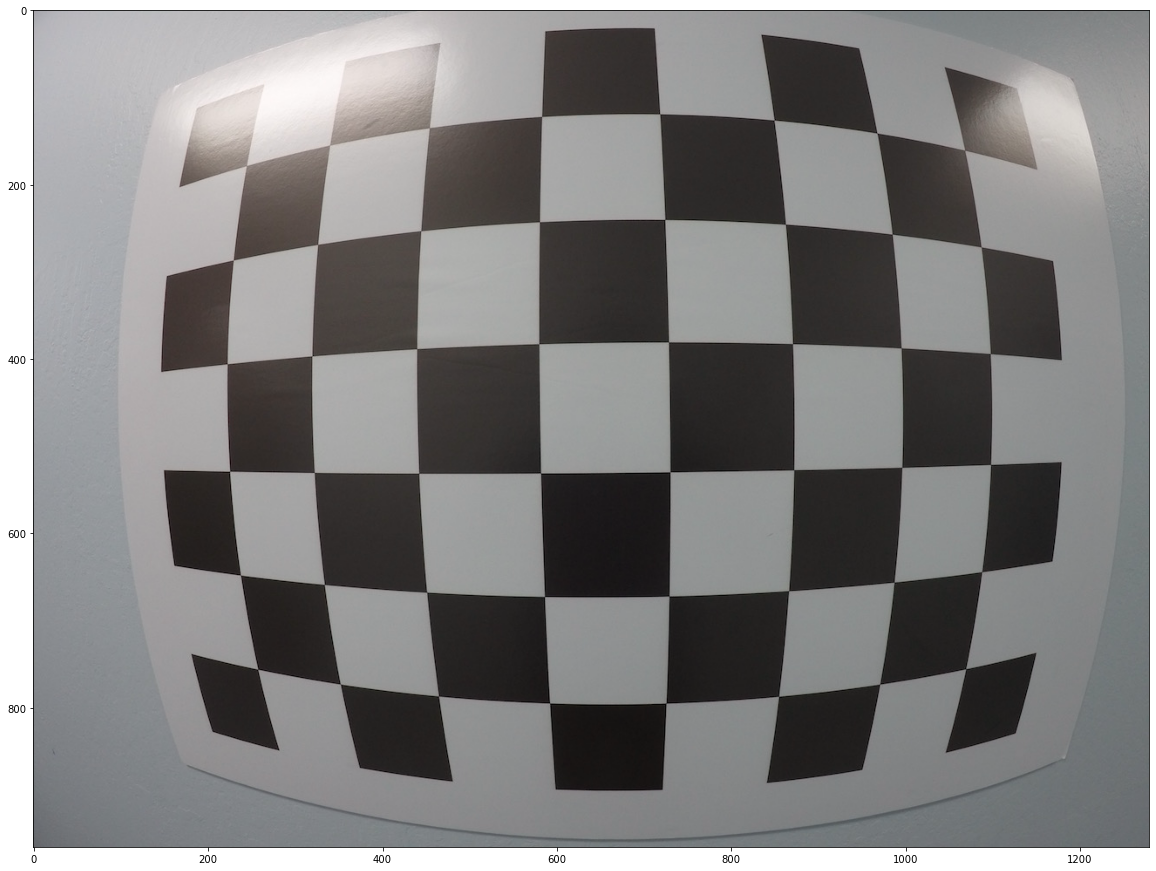

In [15]:
### Display the image
plt.figure(figsize=(20,24))
plt.imshow(img_calib)

Great! We can verify that our chessboard calibration pattern is a grid with starting $x$-$y$-coordinates $\left(0,0\right)$ in the upper-left most grid corner. The lower-right most grid corner has location $\left(6, 4\right)$  To map $\left(\mathrm{row}, \mathrm{column}\right)$ coordinates to chessboard corners, start at the upper-left $\left(0,0\right)$ corner and add $+1$ to each $x$-coordinate moving right one grid square (i.e., from the upper-left corner of the first black square, to the upper-left corner of the next black square). Similarly, add $+1$ to the $y$-coordinate for each move downward on along the grid. We need to use grayscale images for the `findChessboardCorners()` method. So, let's create a method that checks an image at a given path is grayscale.

In [16]:
def is_grayscale(img_path: str) -> bool:
    """Checks if grayscale image by channel count and value.
    Credit: https://stackoverflow.com/a/58791118
    """
    
    img = cv2.imread(img_path)
    if len(img.shape) < 3 or len(img.shape) == 1:
        return True
    # Check that channel values are not same
    b, g, r = img[:,:,0], img[:,:,1], img[:,:,2]
    if (b==g).all() and (b==r).all(): return True
    else: return False

In [17]:
### Checking if our image is grayscale
is_grayscale(file_paths_calib[0])

False

Since our calibration targets are not grayscale images, we can use the `cvtColor()` method to convert each image from RGB colour space to grayscale in the following way:
```
img_gray = cv2.cvtColor(img_rgb, colour_conversion)
```
with the parameters:
* `img_rgb` — the RGB image to convert;
* `colour_conversion` — the OpenCV colour space conversion code;
* `img_gray` — the image converted to grayscale.

A full list of colour-space conversion codes can be referenced in the OpenCV documentation [here](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga4e0972be5de079fed4e3a10e24ef5ef0).

##### Detecting chessboard corners

In [18]:
def find_corners(img_path: str, pattern_size: (int,int), flags=None) -> tuple:
    """Returns the calibration pattern corners.
    
    :param img_path: path to grayscale or BGR color calibration pattern
    :param pattern_size: the (rows, cols) of the 2D calibration pattern
    :param flags: cv2 flags (optional)
    :returns: (bool, List[[float,float]]), tuple with boolean flag and
        the detected corner points if found in image.
    """
    
    img_gray = None
    # Image must be grayscale (convert BGR to color)
    if not is_grayscale(img_path):
        img_gray = cv2.cvtColor(img_calib, cv2.COLOR_BGR2GRAY)
    else:
        # Read grayscale image
        img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # Make sure we are looking at chessboard pattern
    assert cv2.checkChessboard(img_gray, pattern_size) 
    return cv2.findChessboardCorners(img_gray, pattern_size, flags)

In [19]:
### Obtaining chessboard corners (if detected)
pattern_found, corners = find_corners(file_paths_calib[0], PATTERN_SIZE, flags=None)

In [20]:
### Checking if pattern was found
pattern_found

True

In [21]:
def display_corners(img_path: str, pattern_size: (int,int), corners: np.ndarray, 
                    pattern_found: bool=True) -> np.ndarray:
    """Returns the image with detected corners.
    
    """
    
    img_color = None
    # Image must be 8-bit color
    if not is_grayscale(img_path):
        # Open color image
        img_color = cv2.imread(img_path)
        # Draw detected corners on calibration image
        img = cv2.drawChessboardCorners(image=img_color,
                                        patternSize=pattern_size,
                                        corners=corners,
                                        patternWasFound=pattern_found)
        return img

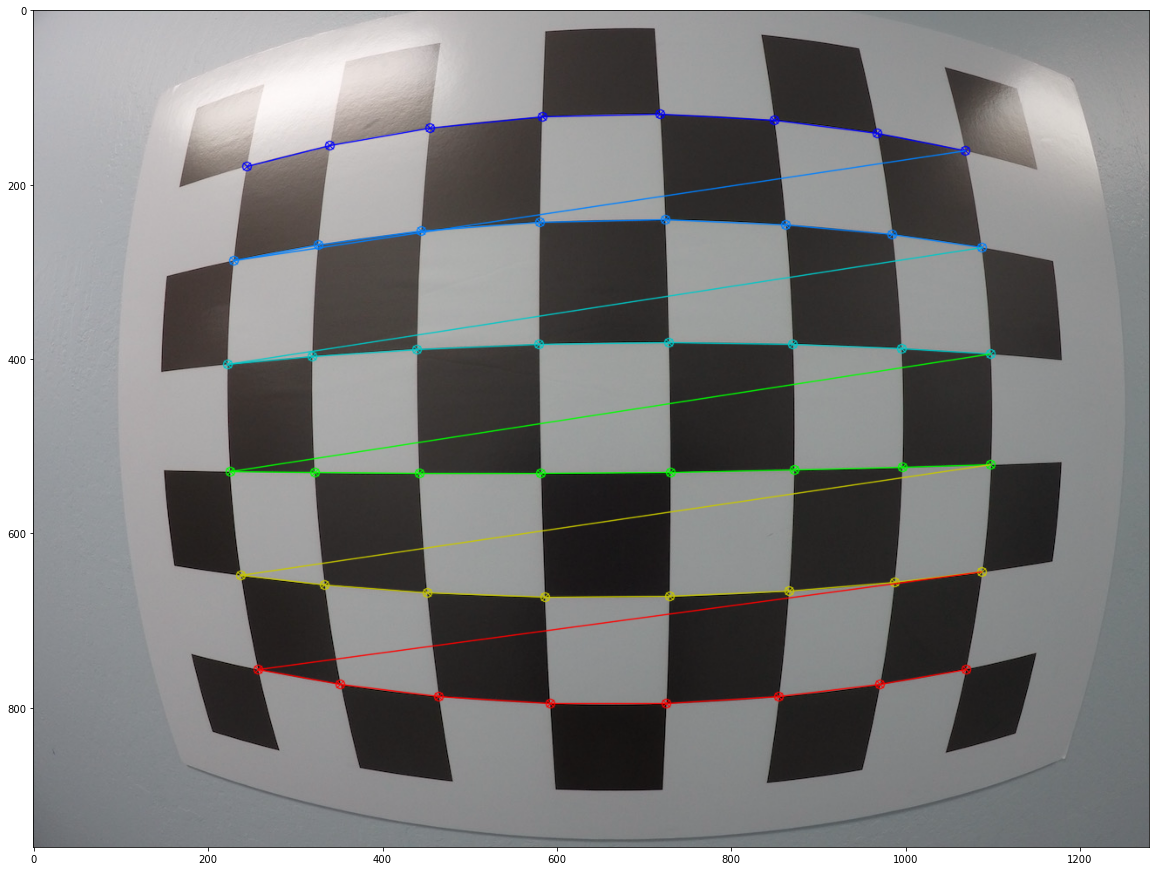

In [22]:
### Displaying the detected corner points
plt.figure(figsize=(20,24))
img = display_corners(file_paths_calib[0], PATTERN_SIZE, corners)
plt.imshow(img)

With the mapping of our ground-truth 3D object coordinates to 2D image projections, we can proceed with the _camera calibration_ step to recover the intrinsic camera parameters, i.e., our calibration matrix $\mathcal{K}$.

#### Calibration with multiple views

We assume that each calibration image is of the same calibration target, the chessboard of size $(6,9)$. We will repeat the `cv2.findChessboardCorners` step for each target image and add the detected corner coordinates and ground-truth corner points to dict objects.

##### Obtaining corner point detections

In [23]:
### Repeating corner detection for all calibration pattern images

In [24]:
def get_corner_points(image_paths: List[str], pattern_size: (int,int),
                      print_detected: bool=False, **params) -> tuple:
    """Returns the lists of object and image points for set of chessboard calibration targets.
    
    :param image_paths: list of file paths of each calibration target image view
    :param pattern_size: known 2D pattern dimensions (same across all images)
    :param print_detected: optional, boolean to print each image and detected corners
    :returns: lists of known object points and detected chessboard corners
    """

    # Dict to store 3D known calibration pattern corner points
    objpoints = defaultdict(list)
    # Dict to store 2D detected corner points
    imgpoints = defaultdict(list)
    # Initialise inner chessboard corners list of 3D object points
    objp = np.zeros(shape=(np.prod(pattern_size), N_DIMS), dtype=np.float32)
    # Transforming chessboard 3D object points to Euclidean 2-space, i.e., (x, y, z=0)
    objp[:,:2] = np.mgrid[0:pattern_size.n_row, 0:pattern_size.n_col].T.reshape(-1,2)
    # Multiply each grid coordinate by square size (skipping for this problem)
    # Figure to render detected corners
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=axes_pad)
    grid.axes_all[2].set_title('Detected corner points in calibration images')
    # For each calibration image
    for i, img_path in enumerate(image_paths):
        # Get filename of image
        img_fname = os.path.basename(img_path)
        # Get the corner points of calibration pattern
        (pattern_found, corners) = find_corners(img_path, pattern_size, flags=None)
        # Display the detected corners if true
        img = display_corners(img_path, pattern_size, corners, pattern_found)
        # Add image to grid
        try:
            grid[i].imshow(img)
            grid[i].axis('off')
        except IndexError:
            # Fix this
            pass
        # Append detected 2D coordinates to list
        corners = np.array(corners).reshape(len(corners),2)
        imgpoints.update({img_fname : corners})
        # Append ground-truth calibration pattern corner points to list
        objpoints.update({img_fname : objp})
    # Save figure as .png image
    os.makedirs(os.path.dirname(fname), exist_ok=True)
    plt.savefig(fname=fname)
    if print_detected:
        plt.show()
    return objpoints, imgpoints

In [25]:
# ImageGrid parameters
figsize = (24,24)
ncols = 5
nrows = len(file_paths_calib) // ncols
axes_pad = 0.2
fname = os.path.join(DIR_BASE, 'out/2022-08-10-Calibration-Distortion-Correction-Output.png')
grid_params = {'figsize': figsize, 'ncols': ncols, 'nrows': nrows, 'axes_pad': axes_pad, 'fname': fname}

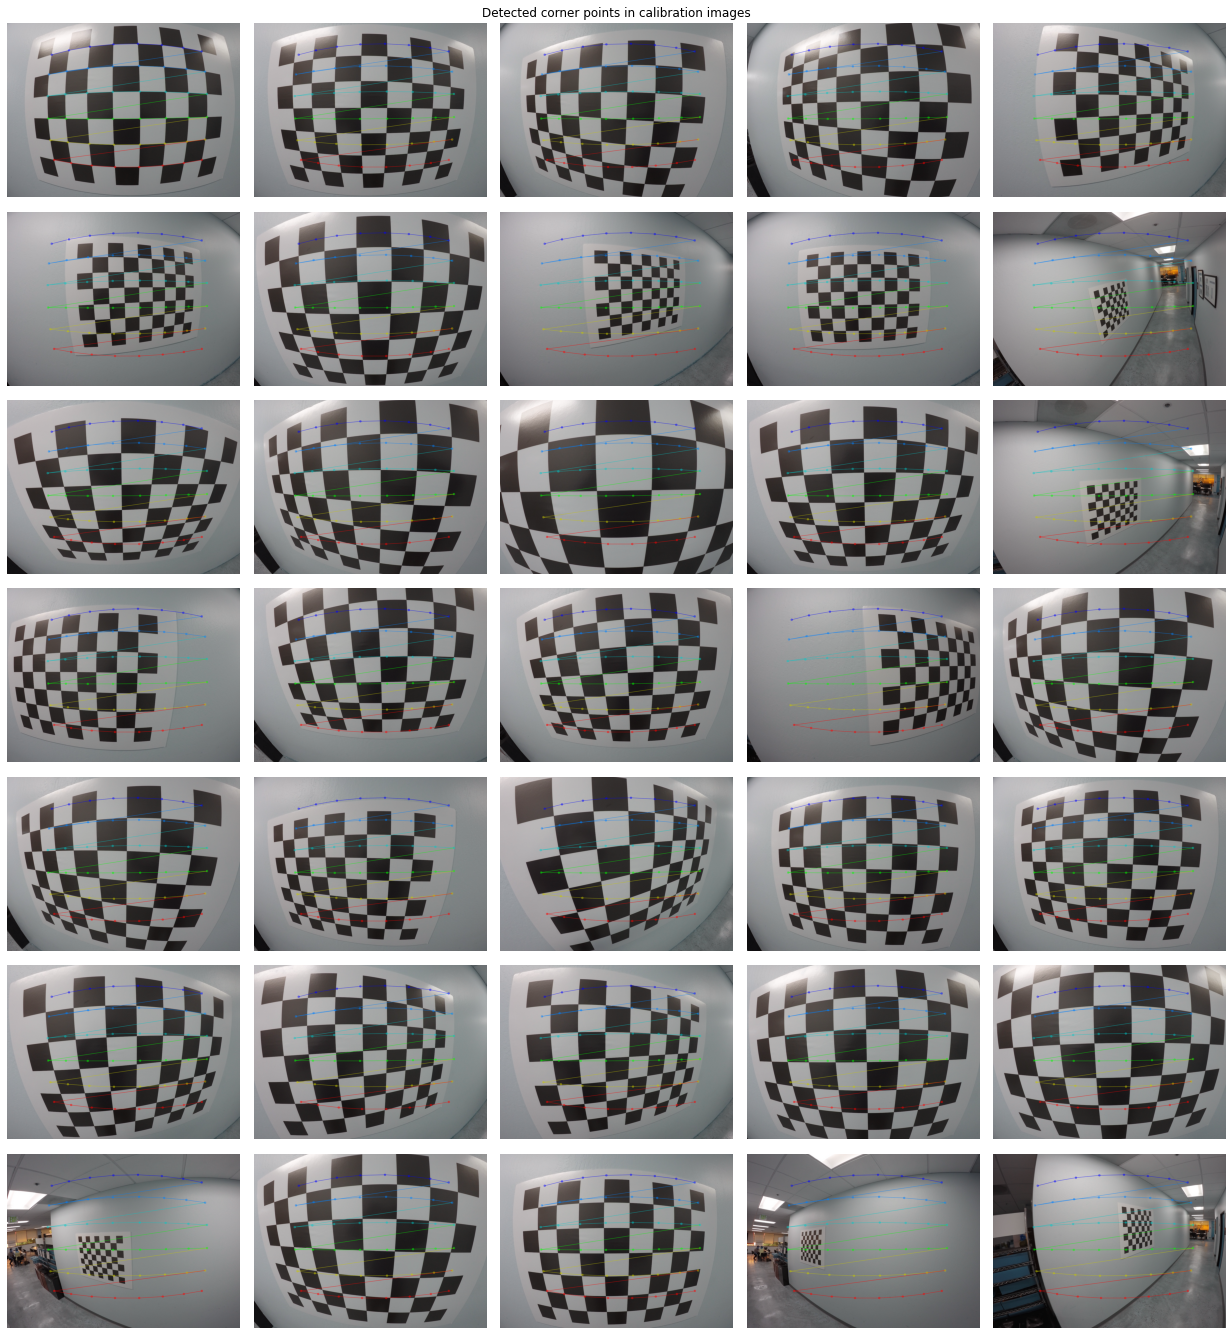

In [26]:
### Getting the detected corner points of the calibration pattern from multiple views
objpoints, imgpoints = get_corner_points(file_paths_calib, PATTERN_SIZE, print_detected=True, **grid_params)

##### Looking at the detection output

In [27]:
### Comparing our data versus that provided to us by Udacity

In [28]:
### Looking at the first five detected corner points in an image
for fname, corners in imgpoints.items():
    print(f'{fname}:\n', corners[:5], '\n ...\n')
    print(f'shape: ({len(imgpoints)}, {len(corners)}, {len(corners[0])})')
    break

GOPR0034.jpg:
 [[244.7138  178.63393]
 [340.30453 155.05074]
 [454.60742 134.9839 ]
 [583.6037  122.03261]
 [719.07336 119.12357]] 
 ...

shape: (36, 48, 2)


In [29]:
### Looking at the first five chessboard corner points
for fname, corners in objpoints.items():
    print(f'{fname}:\n', corners[:5], '\n ...\n')
    print(f'shape: ({len(imgpoints)}, {len(corners)}, {len(corners[0])})')
    break

GOPR0034.jpg:
 [[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]] 
 ...

shape: (36, 48, 3)


##### Evaluating the results

In [30]:
### Comparing our data versus that provided to us by Udacity

In [31]:
# Loading Udacity data for 'GOPR0038.JPG'

In [32]:
dist_pickle, their_objpoints, their_imgpoints = None, None, None
with open(os.path.join(DIR_BASE, 'data/wide_dist_pickle.p'), 'rb') as f:
    dist_pickle = pickle.load(f)
    try:
        their_objpoints = dist_pickle['objpoints']
        their_imgpoints = dist_pickle['imgpoints']
    except KeyError:
        print('KeyError: not found')

In [33]:
dist_pickle.keys()

dict_keys(['mtx', 'objpoints', 'dist', 'imgpoints'])

In [34]:
### Loading the data for the "Original Image"
my_imgpoints = imgpoints['GOPR0038.jpg']
their_imgpoints = np.array(their_imgpoints).reshape(len(their_imgpoints), len(their_imgpoints[0]), 2)

In [35]:
### Looking at Udacity's first five detected corner points of first image
sorted(their_imgpoints[0], key=lambda k: [k[1], k[0]])[:5]

[array([462.56226, 161.33687], dtype=float32),
 array([579.8799 , 169.69809], dtype=float32),
 array([687.8985 , 184.06252], dtype=float32),
 array([782.25586, 201.73724], dtype=float32),
 array([862.1208 , 220.18567], dtype=float32)]

In [36]:
# Comparing our chessboard coordinates
sorted(my_imgpoints, key=lambda k: [k[1], k[0]])[:5]

[array([719.07336, 119.12357], dtype=float32),
 array([583.6037 , 122.03261], dtype=float32),
 array([849.777  , 126.11232], dtype=float32),
 array([454.60742, 134.9839 ], dtype=float32),
 array([968.01654, 140.83008], dtype=float32)]

In [37]:
their_imgpoints[0][:,1]

array([161.33687, 169.69809, 184.06252, 201.73724, 220.18567, 238.08705,
       254.6391 , 270.0466 , 274.1514 , 278.15265, 287.34195, 298.60617,
       310.93723, 322.4511 , 333.13348, 343.03595, 397.9182 , 396.97278,
       399.01202, 402.44266, 406.34726, 410.45865, 414.30374, 418.09418,
       524.49   , 518.86096, 512.9499 , 507.78   , 503.22232, 499.27304,
       496.08884, 493.45694, 643.9938 , 634.03534, 621.9307 , 608.9703 ,
       596.9634 , 585.75024, 575.8675 , 567.4818 , 749.1405 , 735.9188 ,
       719.671  , 701.35394, 683.638  , 666.7657 , 651.7325 , 637.805  ],
      dtype=float32)

In [38]:
my_imgpoints[:,1]

array([178.63393, 155.05074, 134.9839 , 122.03261, 119.12357, 126.11232,
       140.83008, 161.26295, 286.68887, 268.99258, 253.2192 , 242.9832 ,
       240.23352, 245.71725, 257.00052, 271.96878, 405.9679 , 396.80222,
       388.82257, 382.95004, 380.75955, 382.8589 , 387.67377, 394.06128,
       529.17615, 530.39575, 531.2084 , 530.9877 , 529.99567, 527.4583 ,
       524.47833, 521.33765, 647.9819 , 658.98834, 668.11523, 672.7975 ,
       672.0668 , 665.8975 , 656.06195, 644.2693 , 756.28784, 772.95807,
       787.0044 , 794.94305, 794.9724 , 787.0036 , 773.1783 , 755.50964],
      dtype=float32)

In [39]:
### Fetching the xs, ys from both lists
their_xs, their_ys = their_imgpoints[0][:,0], their_imgpoints[0][:,1]
my_xs, my_ys = my_imgpoints[:,0], my_imgpoints[:,1]

In [40]:
### Computing error of data with cosine similarity score
# Credit: https://medium.com/@gshriya195/top-5-distance-similarity-measures-implementation-in-machine-learning-1f68b9ecb0a3
from scipy.spatial.distance import cosine
print('Avg. dist. x-coordinates:', cosine(my_xs, their_xs), '\nAvg. dist. y-coordinates:', cosine(my_ys, their_ys))

Avg. dist. x-coordinates: 0.01780855655670166 
Avg. dist. y-coordinates: 0.006804347038269043


##### Camera calibration algorithm in Python

Now that we have our corner detections and known points, let's use the `cv2.calibrateCamera()` method to recover the rotation matrix $\mathcal{R}$ and translation vector $t$ relative to the world coordinate system. Once these are obtained, we can estimate the camera extrinsic parameters and obtain the camera matrix $M$ needed to map 3D world coordinates to 2D projections on the image plane.

In [41]:
test_file = file_paths_test[0]

In [42]:
is_grayscale(test_file)

False

In [43]:
img_size = None
if is_grayscale(test_file):
    img_size = cv2.imread(test_file).shape[::-1]
else:
    img_size = cv2.imread(test_file).shape[1::-1]
img_size

(1280, 960)

In [44]:
### From Udacity's `Correcting-For-Distortion.ipynb`

In [45]:
# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image

def calibrate_camera(object_pts, image_pts, img_size, camera_matrix=None, dist_coeffs=None) -> tuple:
    """Performs camera calibration using photogrammetric approach (Zhang, 2000)
    
    Camera intrinsic and extrinsic parameters are estimated from several views of a
    calibration pattern with a known geometry.
    
    :param object_pts: 2D calibration pattern points of object with known geometry 
    :param img_pts: projections of calibration pattern points in 2D image space
    :param img_size: dimensions of the input images (height, width)
    :param camera_matrix: camera intrinsic parameters matrix
    :returns: tuple of camera intrinsic and extrinsic parameters plus a boolean flag.
    """
    
    return cv2.calibrateCamera(object_pts, image_pts, img_size, camera_matrix, dist_coeffs)

In [46]:
### Formatting our data into lists
imgpoints_list = []
objpoints_list = []
for fname, corners in imgpoints.items():
    imgpoints_list.append(corners)
for fname, corners in objpoints.items():
    objpoints_list.append(corners)

In [47]:
### Estimating the intrinsic and extrinsic parameters from point correspondences

In [48]:
(ret_val, calib_matrix, dist_coeffs, 
 rot_vecs, tr_vec) = cv2.calibrateCamera(objectPoints=objpoints_list,    # Calibration pattern points
                                         imagePoints=imgpoints_list,     # Projections of calib. pattern points
                                         imageSize=img_size,             # Width and height of distorted input img
                                         cameraMatrix=None,              # Camera intrinsic calibration matrix (K)
                                         distCoeffs=None                 # Distortion coefficients vector
                                        )

In [49]:
calib_labels = ['f_x', '0', 'c_x',
                '0', 'f_y', 'c_y',
                '0', '0', '1']
dist_labels = ['k_1', 'k_2', 'p_1', 'p_2', 'k_3']

In [50]:
def label_matrix_values(values: np.ndarray, labels: List[str]) -> np.ndarray:
    labelled = []
    for label, value in zip(labels, values.flatten()):
        labelled.append([f'{label}: {value:0.3f}'] if label not in ['0', '1'] else [value])
    return np.array(labelled)

In [51]:
# True if calibration was successful
if ret_val:
    print(' Calibration successful!\n', '-'*23)
    print('--Calibration matrix--')
    mtx = pd.DataFrame(data=label_matrix_values(calib_matrix, calib_labels).reshape(3,3))
    print(mtx.to_string())
    print('\n\n--Distortion coefficients--')
    mtx = pd.DataFrame(data=label_matrix_values(dist_coeffs, dist_labels).reshape(-1))
    print(mtx.to_string())

 Calibration successful!
 -----------------------
--Calibration matrix--
               0              1             2
0  f_x: 1451.678            0.0  c_x: 644.584
1            0.0  f_y: 1460.538  c_y: 505.925
2            0.0            0.0           1.0


--Distortion coefficients--
             0
0  k_1: -1.713
1   k_2: 4.157
2  p_1: -0.007
3   p_2: 0.008
4  k_3: -5.801


### 2.2. Distortion Correction

#### Considerations for our input data

Our task is as following:
![Figure 4. Original (distorted) image and its undistorted image after processing.](figures/2022-08-10-Figure-4-Udacity-Original-and-Undistorted.png)
$$
\begin{align}
    \textrm{Fig. 4. Original (distorted) image, left, and its undistorted image, right, after processing.} \\
    \end{align}
$$

We will be correcting the barrel distortion in the test image, shown on the left of Fig. 2., using the OpenCV `calibrateCamera()` and `undistort()` methods.

#### Distortion correction algorithm in Python

In [52]:
### From Udacity's `Correcting-For-Distortion.ipynb`

In [53]:
def undistort_calibrated(img_paths: List[str], camera_matrix: np.ndarray, dist_coeffs: np.ndarray, 
                         new_camera_matrix: np.ndarray=mtx) -> np.ndarray:
    """Undistortes the image containing radial distortion.
    
    The distortion parameters are estimated from several views of a
    calibration pattern with precisely-known geometry. The camera is
    assumed to be calibrated, i.e., the intrinsic and extrinsic
    parameters are known a priori.
    
    :param img_paths: paths to raw image files to undistort
    :param mtx: the camera calibration matrix K
    :param distCoeffs: the vector of distortion coefficients in the form
        (k1, k2, p1, p2[, k3[, k4, k5, k6[, s1, s2, s3, s4[, \tau_{x}, \tau_{y}}]]]])
    :param newCameraMatrix: the camera matrix of the distorted image, by default this is 
        same as `cameraMatrix` unless scale/shift applied with e.g., `getOptimalNewCameraMatrix()`
    :returns: the corrected image transformed with the computed geometric re-mapping.
    """
    
    images = defaultdict(str)
    for i, img_path in enumerate(img_paths):
        # Get filename of image
        img_fname = os.path.basename(img_path)
        if is_grayscale(img_path):
            img_dist = cv2.imread(img_path, cv2.IMREAD_GRAY)
        else:
            img_dist = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img_corr = cv2.undistort(src=img_dist, cameraMatrix=camera_matrix, 
                         distCoeffs=dist_coeffs, newCameraMatrix=camera_matrix)
        images.update({os.path.basename(img_fname) : img_corr})
    return images

#### Evaluating the results

In [54]:
### Applying camera calibration and distortion correction
undistorted_image_files = undistort_calibrated(file_paths_test, calib_matrix, dist_coeffs, calib_matrix)

In [55]:
img_original = cv2.imread(file_paths_test[1], cv2.IMREAD_COLOR)
### Get the corrected raw test image (undistorted)
img_fname_test = os.path.basename(file_paths_test[1])
img_undistorted = undistorted_image_files[img_fname_test]

In [56]:
file_paths_test

['CarND-Camera-Calibration/calibration_wide/test_image.jpg',
 'CarND-Camera-Calibration/calibration_wide/GOPR0038.jpg']

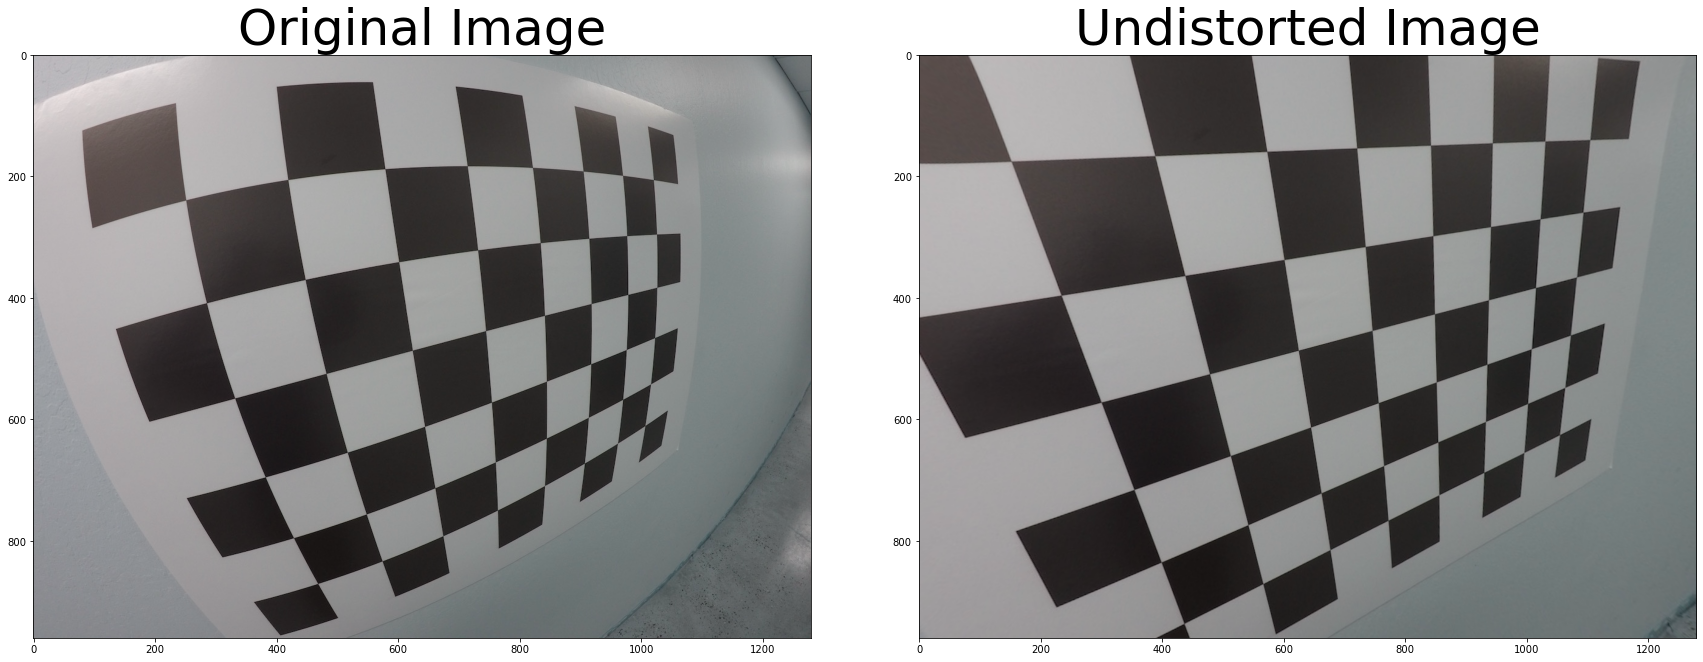

In [57]:
### Plotting the original and corrected images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_original)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

![Figure 4. Original (distorted) image and its undistorted image after processing.](figures/2022-08-10-Figure-4-Udacity-Original-and-Undistorted.png)

In [58]:
def solution(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def test(student_answer, img_path):
    # Read in the saved objpoints and imgpoints
    dist_pickle = pickle.load( open( "data/wide_dist_pickle.p", "rb" ) )
    objpoints = dist_pickle["objpoints"]
    imgpoints = dist_pickle["imgpoints"]    
    # Read in an image
    img = cv2.imread(img_path)    
    # Get undistorted answer
    answer = solution(img, objpoints, imgpoints)    
    if np.isclose(img, student_answer).all():
        feedback = 'Oops! looks like no distortion correction was applied!'
    elif np.isclose(answer, student_answer).all():
        feedback = 'Correct! Nice work.'
    else:
        feedback = 'Oops! that looks different than my result!'    
    return feedback

In [59]:
test(img_undistorted, 'CarND-Camera-Calibration/calibration_wide/GOPR0038.jpg')

'Oops! that looks different than my result!'

**Note**: from the above test it appears that the data in the `pickle` file Udacity provided us with is incorrect, as it was generated from a test image that we were not given access to. I have opened an [issue](https://github.com/udacity/CarND-Camera-Calibration/issues/5) on GitHub and started a [forum post](https://knowledge.udacity.com/questions/886851) to discuss this further.

## 3. Closing Remarks
##### Alternatives
* Real-time radial distortion correction algorithms (model-based approach [here](https://arxiv.org/abs/2010.04203))
* Deep learning-based approach for radial distortion correction (many linked [here](https://github.com/subeeshvasu/Awesome-Image-Distortion-Correction#Radial-Distortions))
* Linear model calibration from single view (paper [here](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.12.6792&rep=rep1&type=pdf))
* Self-calibration models, i.e., no calibration target needed (paper [here](https://www.cv-foundation.org/openaccess/content_cvpr_2013/papers/Brito_Radial_Distortion_Self-Calibration_2013_CVPR_paper.pdf)) 

## 4. Future Work
- [ ] Use a more robust model (e.g., Brown or Fitzgibbon division model) to correct for radial distortion;
- [ ] Check out real-time radial distortion correction models (e.g., Valtonen Örnhag et al., 2021)

## Credits
This assignment was prepared by Cezanne Camacho, Sudhanshu Kulshrestha and Michael Virgo et al., Winter 2021 (link [here](https://github.com/udacity/CarND-Camera-Calibration)).

References:
* [1] Zhang, Z. A Flexible New Technique for Camera Calibration, IEEE Transactions on Pattern Analysis & Machine Intelligence, 22(11):1330-1334, 2000. doi:10.1109/34.888718
* [2] Hartley R, Zisserman A. Computation of the Camera Matrix P. In: Multiple View Geometry in Computer Vision. 2nd ed. Cambridge: Cambridge University Press; 2004. p. 190–192. doi:10.1017/CBO9780511811685.011
* [3] Bauer, A., Vo, S. et al. Computational optical distortion correction using a radial basis function-based mapping method, Opt. Express (20)14906-14920, 2012. doi:10.1364/OE.20.014906

Helpful resources:
* [The Geometry of Perspective Projection | CSE791E](https://www.cse.unr.edu/~bebis/CS791E/Notes/PerspectiveProjection.pdf)
* [Camera Calibration using Zhang's method | C. Stachniss on YouTube](https://www.youtube.com/watch?v=-9He7Nu3u8s&t=63s)
* [Camera Calibration | S. Nayar on YouTube](https://youtu.be/GUbWsXU1mac)
* [Lecture 14. Camera Calibration | CMSC691 by Jesus J. Caban](https://www.csee.umbc.edu/~caban1/Fall2010/CMSC691//Schedule_files/Docs/14-CameraCalibration.pdf)
* [Camera Calibration and 3D Reconstruction | OpenCV](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html)
* [Top 5 Distance Similarity Measures in Machine Learning | Medium](https://medium.com/@gshriya195/top-5-distance-similarity-measures-implementation-in-machine-learning-1f68b9ecb0a3)
* [Efficient Real-Time Radial Distortion Correction for UAVs | Lund University](https://www.youtube.com/watch?v=nIdlWQyGMMY)
* [Awesome Image Distortion Correction | GitHub](https://github.com/subeeshvasu/Awesome-Image-Distortion-Correction#Radial-Distortions)